In [240]:
#https://proceedings.neurips.cc/paper/2020/file/fdbe012e2e11314b96402b32c0df26b7-Paper.pdf
#http://proceedings.mlr.press/v48/wei16.pdf

import sys
sys.path.append("../../")

import tensorflow as tf
from tensorflow import keras
from pmlb import fetch_data
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import dmp.task.aspect_test.aspect_test_utils as aspect_test_utils
from dmp.data.pmlb import pmlb_loader

_datasets = pmlb_loader.load_dataset_index()

In [384]:
def make_model(dataset, widths):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    model = keras.models.Sequential()
    model.add(tf.keras.Input(shape=inputs.shape[1:]))
    for width in widths:
        model.add(keras.layers.Dense(width, activation='relu'))
    model.add(keras.layers.Dense(outputs.shape[1], activation=output_activation))

    model.compile(optimizer='adam',
        loss = run_loss,
        #   loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', ],
        )

    # print(model.summary())
    return model


def default_initializer(source_model, dest_model):
    for i, l in enumerate(source_model.layers):  # inserts old weights into new model
        old_width = l.output_shape[1]
        old_weights = l.get_weights()
        # new_weights = new_model.layers[i].get_weights()

        new_layer = dest_model.layers[i]
        new_weights = new_layer.get_weights()

        # new_weights[0] = new_weights[0] * 0
        # new_weights[1] = new_weights[1] * 0

        print(
            f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

        new_weights[0][:old_weights[0].shape[0],
                       :old_weights[0].shape[1]] = old_weights[0]
        new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
        new_layer.set_weights(new_weights)


def grow_network_replace(dataset, source_model, new_widths, initializer=default_initializer):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    dest_model = keras.Sequential()
    input_shape = source_model.input_shape

    print(f'growing {len(source_model.layers)}')

    for i, l in enumerate(source_model.layers):  # adds modified layers to new model
        old_width = l.output_shape[1]
        new_width = new_widths[i] if len(new_widths) > i else old_width
        dest_model.add(keras.layers.Dense(new_width, activation=l.activation))

    dest_model.build(input_shape)  # makes new model (and initialized weights)

    initializer(source_model, dest_model)

    dest_model.compile(optimizer='adam',
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['accuracy'])
    return dest_model

def plot_histories(configs, metric_trace, size_trace, x_axis_trace, colors=None):
    if colors is None:
        colors = cm.get_cmap('tab10').colors

    sequence_number = 0
    def plot_sequence(x, y):
        nonlocal sequence_number
        plt.plot(x,y,
              'o-',               markersize=4, 
              color=colors[sequence_number % len(colors)],
              alpha = .7,
              )
        sequence_number += 1

    start = 0
    for i, s in enumerate(size_trace):
        if i > 0 and size_trace[i-1] != s:
            plot_sequence(x_axis_trace[start:i], metric_trace[start:i])
            start = i
    plot_sequence(x_axis_trace[start:], metric_trace[start:])


def plot_effort(configs, trace, metric = 'val_loss', colors=None):
    plot_histories(configs, trace[metric], trace['size'], trace['effort'], colors=colors)

def plot_epoch(configs, trace, metric = 'val_loss', colors=None):
    plot_histories(configs, trace[metric], trace['size'], trace['epoch'], colors=colors)

def plot_delta_efficiency(configs, trace, metric = 'loss', colors=None):
    plot_histories(configs, -np.diff(trace[metric], 1) /  trace['size'][1:], trace['size'][1:], trace['effort'][1:], colors=colors)

def plot_improvement(configs, trace, metric = 'loss', colors=None):
    plot_histories(configs, -np.diff(trace[metric], 1), trace['size'][1:], trace['effort'][1:], colors=colors)

In [218]:
from typing import Iterable 

def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def scaling_initializer(source_model, dest_model, scale = .1):
    for i, l in enumerate(source_model.layers):  # inserts old weights into new model
        old_width = l.output_shape[1]
        old_weights = l.get_weights()

        new_layer = dest_model.layers[i]
        new_weights = new_layer.get_weights()

        old_std = np.std(np.fromiter(flatten(old_weights), dtype=float))
        new_std = np.std(np.fromiter(flatten(new_weights), dtype=float))
        adjustment = scale * (old_std / new_std)
        new_weights[0] *= adjustment
        new_weights[1] *= adjustment

        # new_weights[0] = new_weights[0] * 0
        # new_weights[1] = new_weights[1] * 0

        print(
            f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

        new_weights[0][:old_weights[0].shape[0],
                       :old_weights[0].shape[1]] = old_weights[0]
        new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
        new_layer.set_weights(new_weights)


In [119]:
# X, y = fetch_data('mnist', return_X_y=True)
# X, y = fetch_data('sleep', return_X_y=True)

def load_dataset(name):
    dataset_series, inputs, outputs =  \
                pmlb_loader.load_dataset(_datasets, name)
    run_config = aspect_test_utils.prepare_dataset(
                'shuffled_train_test_split',
                .2,
                0.0,
                {},
                dataset_series['Task'],
                inputs,
                outputs,
            )

    train_inputs = run_config['x']
    train_outputs = run_config['y']
    test_inputs = run_config['validation_data'][0]
    test_outputs = run_config['validation_data'][1]

    num_inputs = inputs.shape[1:]
    num_outputs = outputs.shape[1]
    output_activation, run_loss = \
                aspect_test_utils.compute_network_configuration(num_outputs, dataset_series)
    dataset = (dataset_series, inputs, outputs,train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss)   
    return dataset



In [414]:
def make_equal_epochs_growth_trigger(epoch_limit):
    def growth_trigger(model, epochs_at_stage, loss_history):
        return epochs_at_stage >= epoch_limit
    return growth_trigger


def make_scheduled_growth_trigger(schedule):
    stage = 0

    def growth_trigger(model, epochs_at_stage, loss_history):
        nonlocal stage
        if epochs_at_stage < schedule[stage]:
            return False
        stage += 1
        return True
    return growth_trigger

def make_improvement_growth_trigger(threhsold, final_stage, final_epochs):
    stage = 0
    def growth_trigger(model, epochs_at_stage, loss_history):
        nonlocal stage
        if stage < final_stage:
            if epochs_at_stage >= 1 and (loss_history[-1] / loss_history[-2]) > 1 - threhsold:
                stage += 1
                return True
            return False
        else:
            return epochs_at_stage >= final_epochs
    return growth_trigger

def make_efficiency_growth_trigger(min_efficiency, final_stage, final_epochs):
    stage = 0
    def growth_trigger(model, epochs_at_stage, loss_history):
        nonlocal stage

        size = \
            aspect_test_utils.count_trainable_parameters_in_keras_model(model)

        if stage < final_stage:
            efficiency = (loss_history[-2] - loss_history[-1]) / size
            if epochs_at_stage > 1 and efficiency < min_efficiency:
                stage += 1
                return True
            return False
        else:
            return epochs_at_stage >= final_epochs
    return growth_trigger

def do_grow_train(configs, dataset, initializer, growth_trigger):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    metrics = ['loss', 'val_loss']
    trace = {m: [] for m in metrics}
    trace['size'] = []
    trace['effort'] = []
    trace['epoch'] = []

    epoch = 0
    effort = 0
    model = None
    for i, widths in enumerate(configs):

        if model is None:
            model = make_model(dataset, widths)
        else:
            model = grow_network_replace(
                dataset, model, widths, initializer=initializer)
        print(model.summary())

        size = \
            aspect_test_utils.count_trainable_parameters_in_keras_model(model)
        trace['size'].append(size)
        trace['loss'].append(model.evaluate(train_inputs,
                                            train_outputs)[0])
        trace['val_loss'].append(
            model.evaluate(test_inputs, test_outputs)[0])
        trace['effort'].append(effort)
        trace['epoch'].append(epoch)

        # fit_result = model.fit(train_inputs, train_outputs, epochs = 10)
        # print(fit_result.history)
        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += size

            fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(test_inputs, test_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   )
            epochs_at_stage = end_epoch
            print(fit_result.history)

            for m in metrics:
                trace[m].append(fit_result.history[m][0])
            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(effort)
            if growth_trigger(model, epochs_at_stage, trace['loss']):
                break

    return model, trace


In [297]:
dataset = load_dataset('sleep')

configs = [
    [2, 2],
    [4, 4],
    [8, 8],
    [16, 16],
]



In [341]:
full_configs = [([configs[-1][0], sum([c[1] for c in configs])])]

full_model, full_trace = do_grow_train(full_configs, dataset, 
    default_initializer, 
    make_equal_epochs_growth_trigger(20),
    )

Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_633 (Dense)            (None, 16)                2272      
_________________________________________________________________
dense_634 (Dense)            (None, 30)                510       
_________________________________________________________________
dense_635 (Dense)            (None, 5)                 155       
Total params: 2,937
Trainable params: 2,937
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 7s 3ms/step - loss: 0.7486 - accuracy: 0.7264 - val_loss: 0.7019 - val_accuracy: 0.7384
{'loss': [0.7485650181770325], 'accuracy': [0.726423978805542], 'val_loss': [0.7019070982933044], 'val_accuracy': [0.7383627891540527]}
Epoch 2/2
2648/2648 [==============================] - 5s 2ms/step - loss: 0.6828 - accuracy: 0.7483 - val

In [194]:
default_model, default_trace = do_grow_train(configs, dataset, 
    default_initializer,
    make_equal_epochs_growth_trigger(12),
    )

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_380 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_381 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_382 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
662/662 [==============================] - 1s 2ms/step - loss: 1.6219 - accuracy: 0.1128
Epoch 2/2
2648/2648 [==============================] - 6s 2ms/step - loss: 1.1808 - accuracy: 0.5635 - val_loss: 1.0239 - val_accuracy: 0.6642
{'loss': [1.1807763576507568], 'accuracy': [0.5635342001914978], 'val_loss': [1.0239408016204834], 'val_accuracy': [0.664243221282959]}
Epoch 3/3
2

In [219]:
scaling_model, scaling_trace = do_grow_train(configs, dataset, 
    scaling_initializer,
    make_equal_epochs_growth_trigger(12),
    )

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_464 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_465 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_466 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
662/662 [==============================] - 1s 1ms/step - loss: 1.6688 - accuracy: 0.1186
Epoch 2/2
2648/2648 [==============================] - 6s 2ms/step - loss: 1.1270 - accuracy: 0.5840 - val_loss: 0.8843 - val_accuracy: 0.6937
{'loss': [1.126959204673767], 'accuracy': [0.584011971950531], 'val_loss': [0.884255051612854], 'val_accuracy': [0.693702220916748]}
Epoch 3/3
2648

In [231]:
scaling_model, scaling_trace_0_2 = do_grow_train(configs, dataset, 
    lambda a, b : scaling_initializer(a,b,0.2),
    make_equal_epochs_growth_trigger(12),
    )

Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_488 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_489 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_490 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
662/662 [==============================] - 1s 2ms/step - loss: 1.5745 - accuracy: 0.3464
Epoch 2/2
2648/2648 [==============================] - 6s 2ms/step - loss: 1.1178 - accuracy: 0.6201 - val_loss: 1.0494 - val_accuracy: 0.6333
{'loss': [1.1178489923477173], 'accuracy': [0.6201283931732178], 'val_loss': [1.0493724346160889], 'val_accuracy': [0.6333207488059998]}
Epoch 3/3


In [267]:
scaling_model, scaling_trace_0_01 = do_grow_train(configs, dataset, 
    lambda a, b : scaling_initializer(a,b,0.01),
    make_equal_epochs_growth_trigger(12),
    )

Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_518 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_519 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_520 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
662/662 [==============================] - 1s 1ms/step - loss: 1.6170 - accuracy: 0.1364
Epoch 2/2
2648/2648 [==============================] - 5s 2ms/step - loss: 1.1734 - accuracy: 0.5757 - val_loss: 1.0306 - val_accuracy: 0.6279
{'loss': [1.1733965873718262], 'accuracy': [0.5757264494895935], 'val_loss': [1.0306053161621094], 'val_accuracy': [0.6279388070106506]}
Epoch 3/3


In [413]:
_, increasing_trace_0_1 = do_grow_train(configs, dataset, 
    lambda a, b : scaling_initializer(a,b,0.1),
    make_scheduled_growth_trigger([2**(i+1) for i in range(4)]),
    )

Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_660 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_661 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_662 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 8s 3ms/step - loss: 1.1212 - accuracy: 0.6088 - val_loss: 1.0502 - val_accuracy: 0.6315
{'loss': [1.1212209463119507], 'accuracy': [0.6088095903396606], 'val_loss': [1.050162672996521], 'val_accuracy': [0.6314795613288879]}
Epoch 2/2
2648/2648 [==============================] - 8s 3ms/step - loss: 1.0020 - accuracy: 0.6421 - val_los

In [277]:
_, increasing_trace_4_0_1 = do_grow_train(configs, dataset, 
    lambda a, b : scaling_initializer(a,b,0.1),
    make_scheduled_growth_trigger([2**(i+2) for i in range(4)]),
    )

Model: "sequential_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_545 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_546 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_547 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
662/662 [==============================] - 1s 2ms/step - loss: 1.6197 - accuracy: 0.1748
Epoch 2/2
2648/2648 [==============================] - 6s 2ms/step - loss: 1.2595 - accuracy: 0.5271 - val_loss: 1.0709 - val_accuracy: 0.5401
{'loss': [1.25945246219635], 'accuracy': [0.5271227359771729], 'val_loss': [1.0708891153335571], 'val_accuracy': [0.5400812029838562]}
Epoch 3/3
26

In [313]:
_, threshold_trace_t_0_1_s_0_2 = do_grow_train(configs, dataset, 
    lambda a, b : scaling_initializer(a,b,0.2),
    make_improvement_growth_trigger(0.1, len(configs)-1, 16),
    )

Model: "sequential_188"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_597 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_598 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_599 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 8s 3ms/step - loss: 1.1985 - accuracy: 0.5507 - val_loss: 1.0518 - val_accuracy: 0.6043
{'loss': [1.1985220909118652], 'accuracy': [0.5506809949874878], 'val_loss': [1.0518286228179932], 'val_accuracy': [0.6042866706848145]}
Epoch 2/2
2648/2648 [==============================] - 9s 3ms/step - loss: 0.9826 - accuracy: 0.6310 - val_lo

In [415]:
_, efficiency_trace_t_1e5_s_0_1 = do_grow_train(configs, dataset, 
    lambda a, b : scaling_initializer(a,b,0.1),
    make_efficiency_growth_trigger(1e-5, len(configs)-1, 16),
    )

Model: "sequential_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_672 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_673 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_674 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
2648/2648 [==============================] - 9s 3ms/step - loss: 1.0147 - accuracy: 0.6295 - val_loss: 0.8682 - val_accuracy: 0.6874
{'loss': [1.0147093534469604], 'accuracy': [0.6294761896133423], 'val_loss': [0.868243932723999], 'val_accuracy': [0.6874232888221741]}
Epoch 2/2
2648/2648 [==============================] - 9s 3ms/step - loss: 0.8334 - accuracy: 0.7042 - val_los

In [315]:
threshold_trace_t_0_1_s_0_2 = threshold_trace_t_0_9_s_0_2

In [274]:
# target_epochs = 4
# target_size = 16
# slope = (target_epochs ** (-1/3))/np.log(target_size)
# print(slope)

# crconfig = [ ([2**i, 2**i], int(np.ceil( (slope* np.log(2**i))**(-3) ))) for i in range(1,5)]
# print(crconfig)

# _, cubic_trace_0_1 = do_grow_train(crconfig, dataset, lambda a, b : scaling_initializer(a,b,0.1))

0.22721023132436874
[([2, 2], 256), ([4, 4], 32), ([8, 8], 10), ([16, 16], 4)]
Model: "sequential_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_542 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_543 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_544 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
662/662 [==============================] - 1s 2ms/step - loss: 1.6124 - accuracy: 0.1844
Epoch 2/2
1344/2648 [==============>...............] - ETA: 2s - loss: 1.4258 - accuracy: 0.4982

KeyboardInterrupt: 

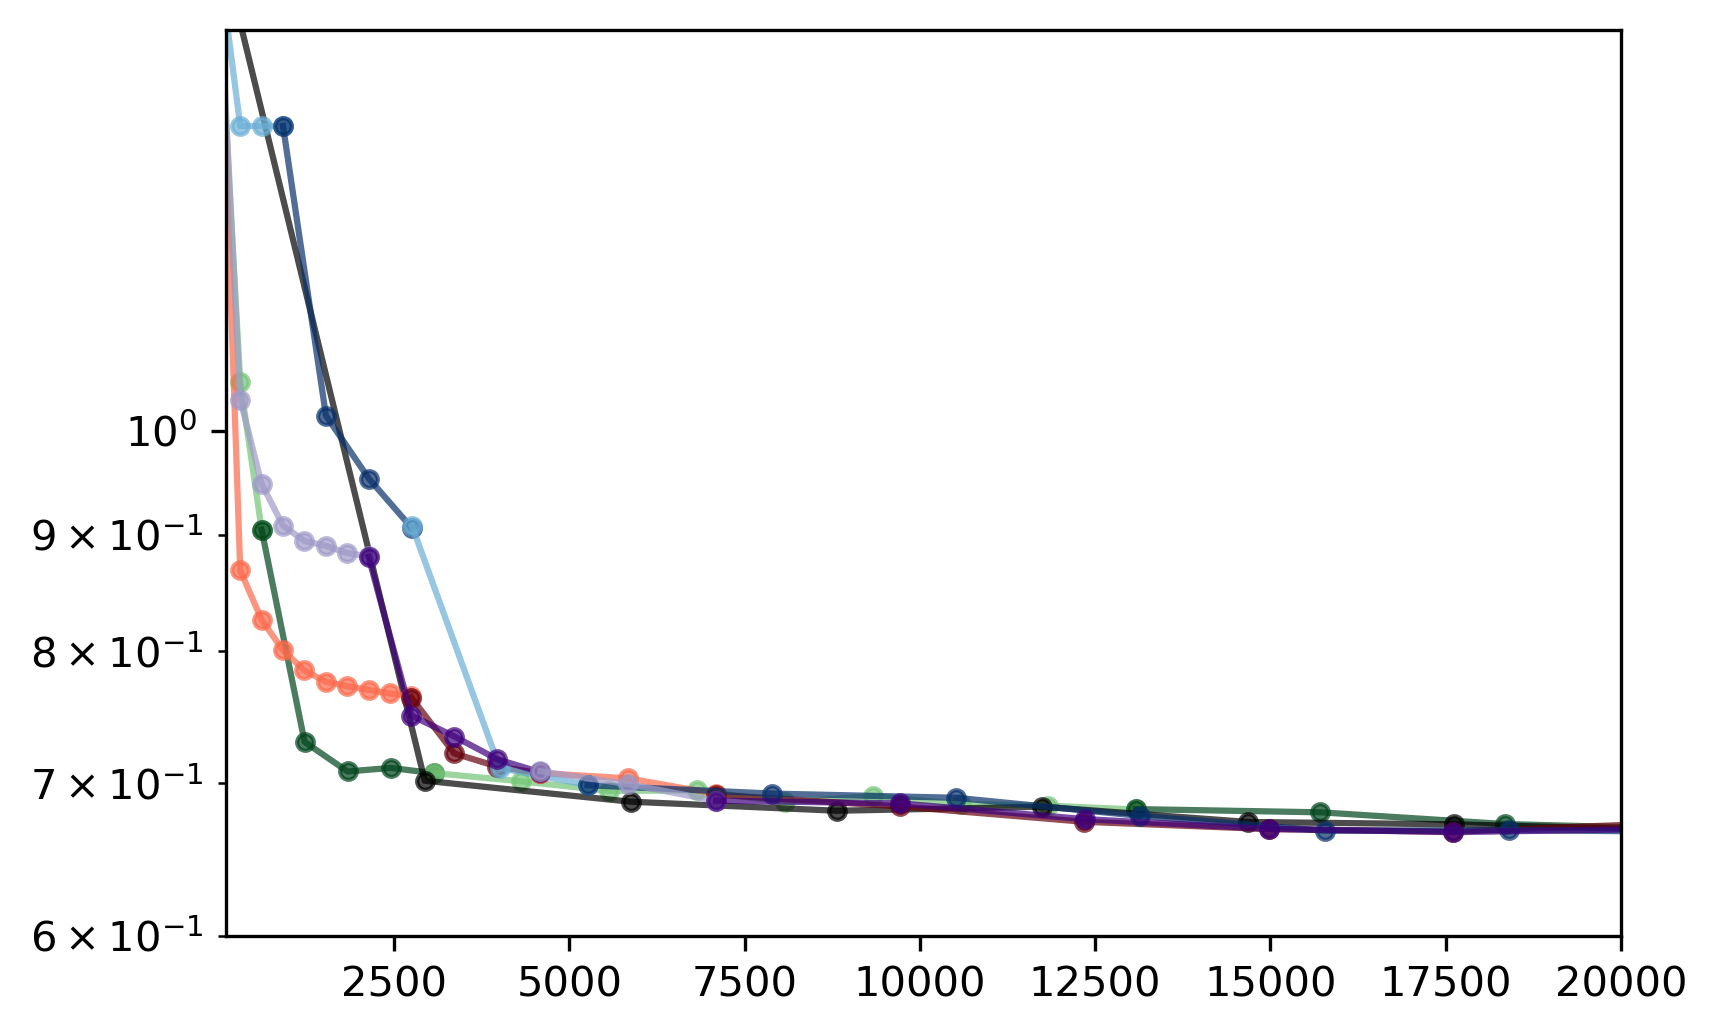

In [434]:
plt.figure(dpi=300)
# plot_effort(configs, scaling_trace_0_01, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 3)))
# plot_effort(configs, increasing_trace_4_0_1, colors = cm.get_cmap('Greens')(np.linspace(.5,1, 2)))

plot_effort(configs, increasing_trace_0_1, colors = cm.get_cmap('Greens')(np.linspace(.5,1, 2)))
plot_effort(full_configs, full_trace, colors=['black']) 
# plot_effort(configs, scaling_trace, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
# plot_effort(configs, scaling_trace_0_2, colors = cm.get_cmap('Purples')(np.linspace(.5,1, 3)))
# plot_effort(configs, threshold_trace_t_0_1_s_0_2, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
plot_effort(configs, efficiency_trace_t_1e5_s_0_1, colors = cm.get_cmap('Reds')(np.linspace(.5,1, 2)))
plot_effort(configs, efficiency_trace_t_1e4_s_0_1, colors = cm.get_cmap('Blues')(np.linspace(.5,1, 2)))
plot_effort(configs, efficiency_trace_t_2e5_s_0_1, colors = cm.get_cmap('Purples')(np.linspace(.5,1, 2)))

plt.yscale('log')
# plt.xlim(100, 60e3)
# plt.ylim(.65, .72)

plt.xlim(100, 20e3)
plt.ylim(.6, 1.5)

# plt.xlim(2e3, 20e3)
# plt.ylim(.65, 1.0)
# plt.xscale('log')
plt.show()

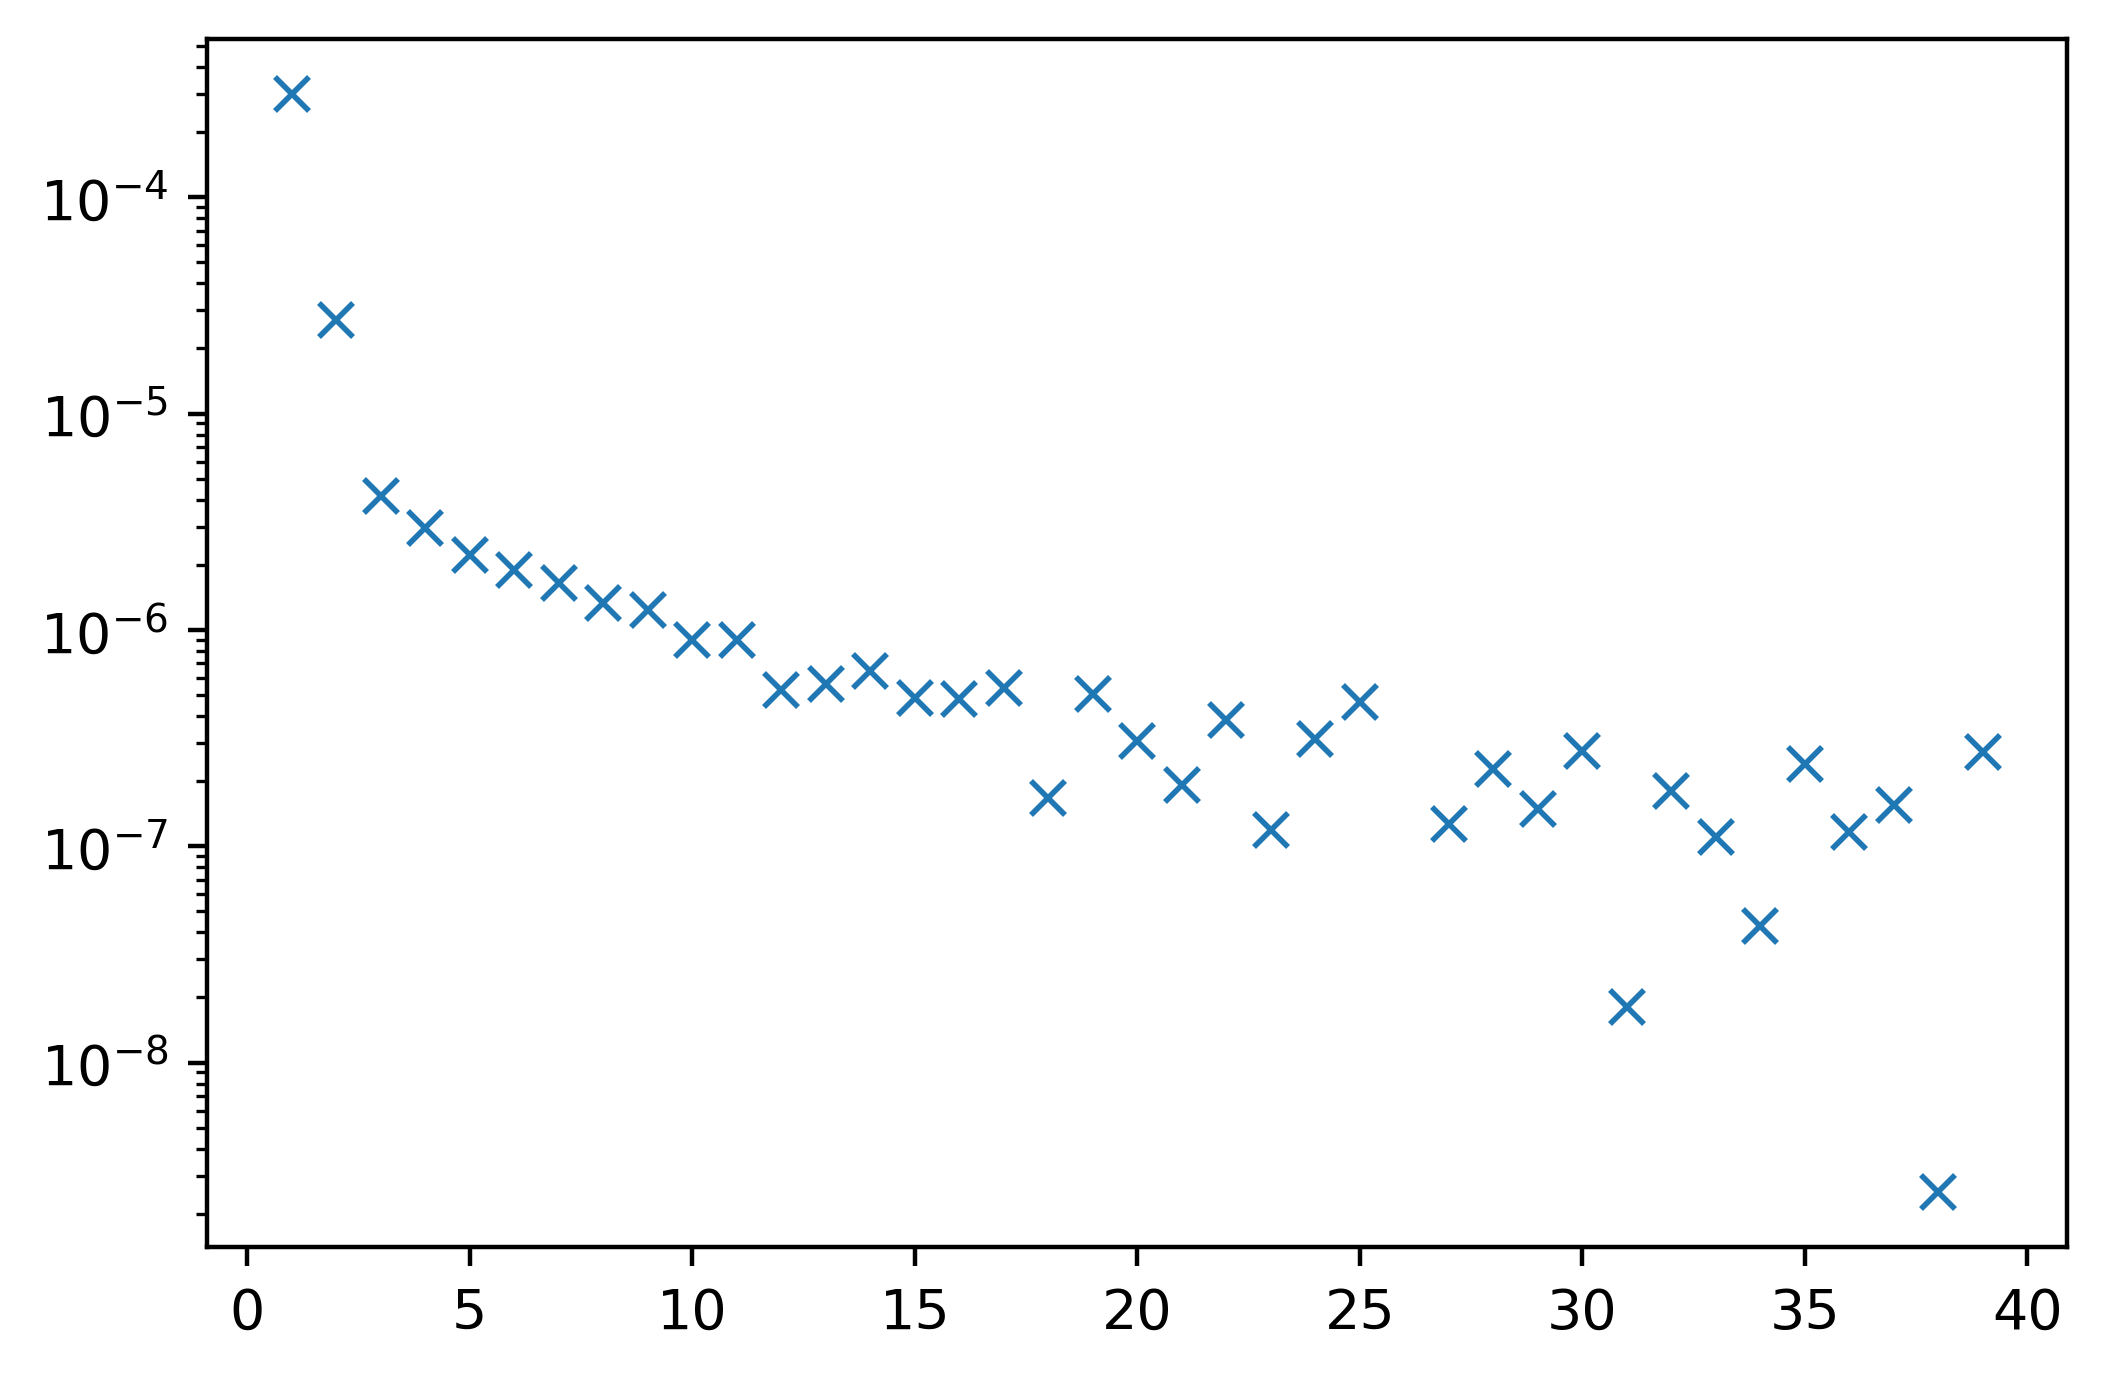

In [333]:
# plt.plot(-np.diff(full_trace['loss'], 1) / full_trace['size'][1:], full_trace['size'][1:])
# plt.plot(full_trace['epoch'][1:], -np.diff(full_trace['loss'], 1))
plt.figure(dpi=400)
plt.semilogy(full_trace['epoch'][1:], -np.diff(full_trace['loss'], 1) /  full_trace['size'][1:], 'x')

In [244]:
plt.figure(dpi=300)
plot_effort(full_configs, full_trace,'loss')
plot_effort(configs, default_trace,'loss')
plot_effort(configs, scaling_trace,'loss')
# plot_effort(configs, scaling_trace_1_0,'loss')
plt.yscale('log')
# plt.xscale('log')
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1800x1200 with 0 Axes>

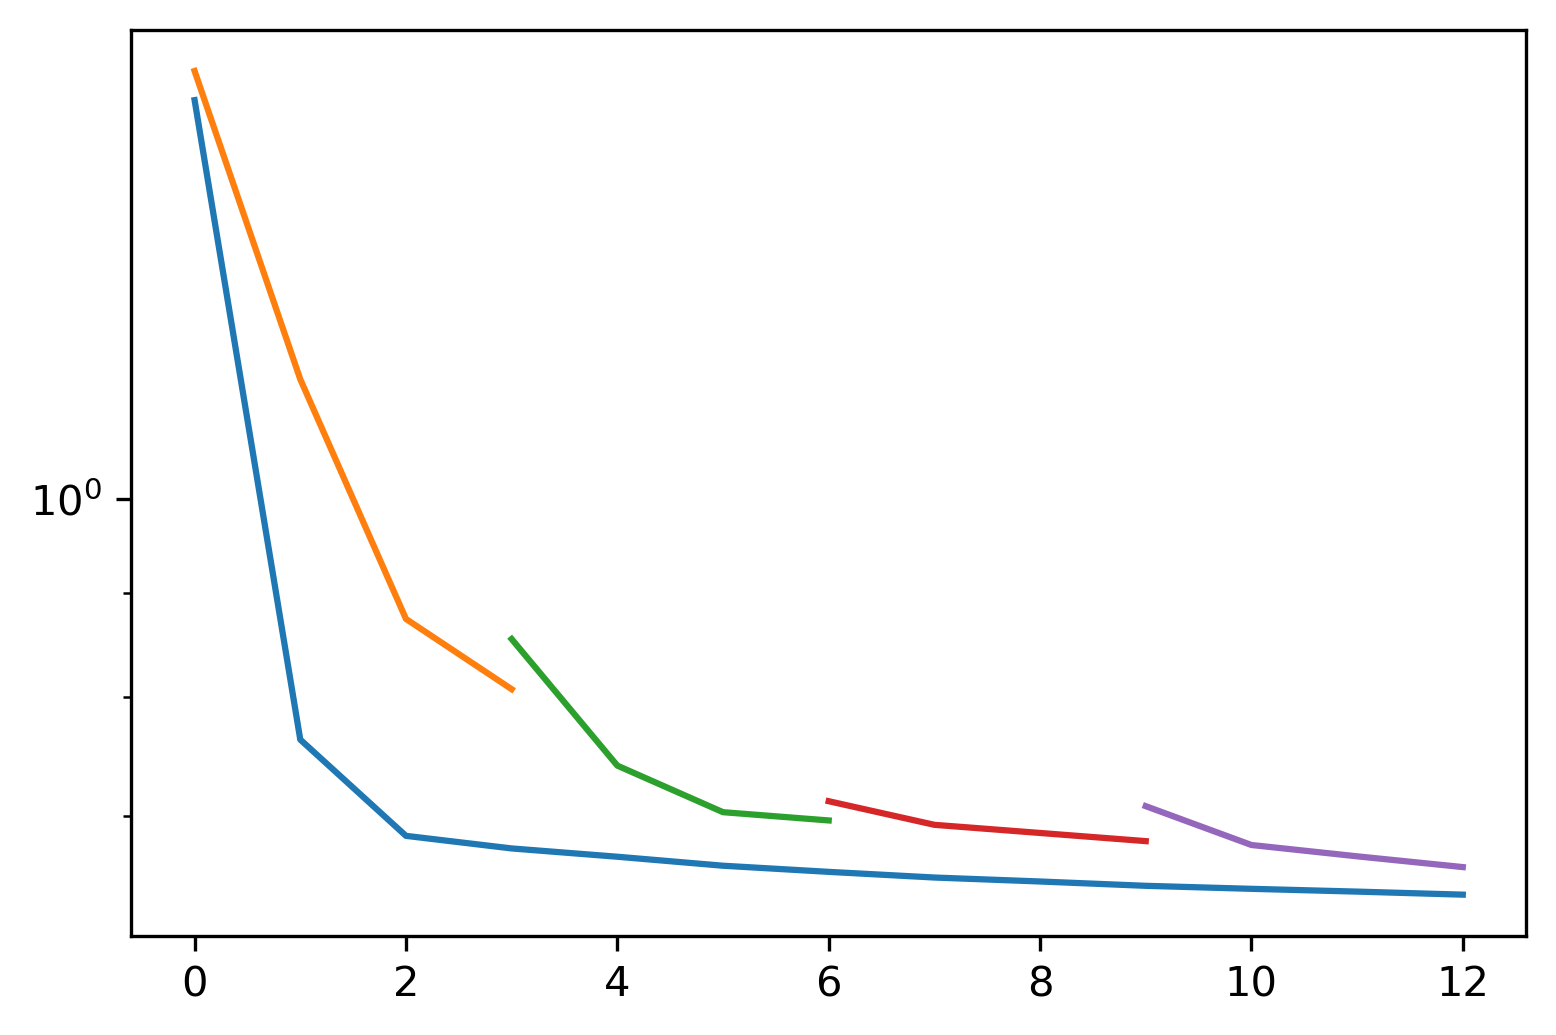

In [152]:
plt.figure(dpi=300)
plot_histories(full_configs, full_loss)
plot_histories(configs, default_loss)
plt.yscale('log')

(array([ 5., 10., 13., 10., 10.,  8., 24., 15.,  4.,  1.]),
 array([-0.70626587, -0.55378973, -0.40131354, -0.24883738, -0.09636122,
         0.05611494,  0.2085911 ,  0.36106727,  0.5135434 ,  0.66601956,
         0.81849575], dtype=float32),
 <BarContainer object of 10 artists>)

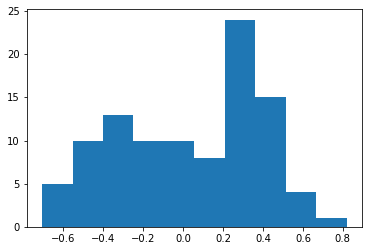

In [8]:
plt.hist(model.layers[1].get_weights()[0].reshape(-1))

In [9]:
input_dim = X.shape[1]

model = keras.models.Sequential()
model.add(tf.keras.Input(shape=(input_dim,)))
model.add(keras.layers.Dense( 10, activation='relu'))
model.add(keras.layers.Dense( 10, activation='relu'))
model.add(keras.layers.Dense( 10, activation='relu'))
model.add(keras.layers.Dense( 10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = [model.evaluate(X,y)[0]] + model.fit(X,y,epochs=10).history['loss']

2188/2188 [==============================] - 3s 1ms/step - loss: 50.0249 - accuracy: 0.1114
Epoch 1/10
2188/2188 [==============================] - 4s 2ms/step - loss: 2.1448 - accuracy: 0.2178
Epoch 2/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5867 - accuracy: 0.3324
Epoch 3/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5085 - accuracy: 0.3461
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.4743 - accuracy: 0.3662
Epoch 5/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.2855 - accuracy: 0.4830
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.2022 - accuracy: 0.5221
Epoch 7/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.1428 - accuracy: 0.5456
Epoch 8/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.1125 - accuracy: 0.5607
Epoch 9/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.0984 - accurac

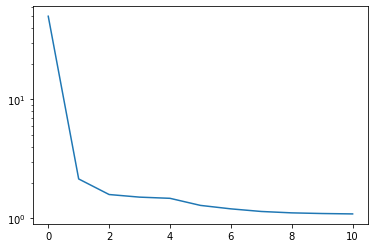

In [10]:
plt.plot(np.arange(len(history)),history)
plt.yscale('log')

(array([10.,  8.,  6., 12., 14., 12.,  8., 10., 10., 10.]),
 array([-0.5364622 , -0.4300101 , -0.32355803, -0.21710595, -0.11065388,
        -0.0042018 ,  0.10225028,  0.20870236,  0.31515443,  0.4216065 ,
         0.5280586 ], dtype=float32),
 <BarContainer object of 10 artists>)

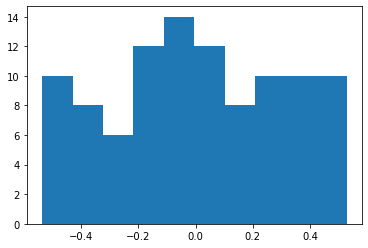

In [46]:
plt.hist(model.layers[1].get_weights()[0].reshape(-1))

In [23]:
# model.fit(X,y,epochs=5, validation_split=0.2, callbacks=keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 min_delta=0,
#                 patience=0,
#                 verbose=0,
#                 mode='auto',
#                 baseline=None,
#                 restore_best_weights=False
#             ))

(70000, 784)